# **Analysis**

### **Import thư viện**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# =========================
# Project setup
# =========================
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(PROJECT_ROOT)

# =========================
# Analysis utilities
# =========================
from utilities.analysis import (
    classify_street_type,
    clean_district_hcm,
    classify_season,
    classify_zone
)

# =========================
# Visualization utilities
# =========================
from utilities.visualize import (
    visualize_rental_price_analysis,
    plot_price_main_vs_alley,
    plot_monthly_boxplot_seasonality,
    plot_monthly_seasonality_compare,
    visualize_price_by_district,
    plot_amenity_charts
)


## **Câu 1. Giá thuê phòng trọ thay đổi như thế nào giữa các quận khác nhau ở TP.HCM?**

**Câu hỏi:** Giá thuê phòng trọ tại TP.HCM phân bố như thế nào giữa các quận? Liệu có sự phân tầng rõ ràng về mặt bằng giá theo vị trí địa lý, và mức độ chênh lệch giữa khu vực trung tâm và ngoại thành là bao nhiêu?

**Tại sao câu hỏi này quan trọng?**

* **Tối ưu lựa chọn khu vực (Cho người thuê):** Xác định quận nào phù hợp với ngân sách, cân đối giữa chi phí sinh hoạt và khoảng cách đến nơi làm việc/học tập.
* **Chiến lược định giá theo địa lý (Cho chủ nhà/Môi giới):** Hiểu rõ vị thế cạnh tranh của địa điểm cho thuê, tránh định giá sai lệch so với thị trường khu vực.
* **Đánh giá tiềm năng đầu tư:** So sánh tỷ suất sinh lời giữa các quận, nhận diện khu vực có độ ổn định giá cao hoặc tiềm năng tăng trưởng.

### **A. Preprocessing**

1. **Tách tên quận từ địa chỉ:**
   * Sử dụng hàm `apply()` với `lambda` để trích xuất tên quận từ cột `address` (phần trước dấu " - ").

2. **Lọc Top 10 quận có nhiều tin đăng nhất:**
   * Sử dụng `value_counts().nlargest(10)` để đảm bảo tính đại diện thống kê, loại bỏ các quận có số lượng mẫu quá nhỏ.

3. **Loại bỏ outliers cực đoan:**
   * Lọc dữ liệu với điều kiện `price <= 30` triệu để loại bỏ các trường hợp có thể là lỗi dữ liệu hoặc bất động sản đặc biệt (villa, penthouse).

4. **Tính thống kê giá thuê theo quận:**
   * Sử dụng `groupby()` và `agg()` để tính: số lượng tin (`count`), giá trung bình (`mean`), giá trung vị (`median`), giá thấp nhất (`min`), giá cao nhất (`max`).
   * Sắp xếp theo `median` giảm dần để xếp hạng các quận từ đắt đến rẻ.

In [2]:
df = pd.read_csv("../Data/cleaned.csv")
df = df.drop(columns=['title', 'description', 'url'])

# Tách tên quận từ cột address
df['district'] = df['address'].apply(lambda x: x.split(' - ')[0] if isinstance(x, str) else x)

# Lọc top 10 quận có nhiều tin đăng nhất
top_districts = df['district'].value_counts().nlargest(10).index
df_filtered = df[df['district'].isin(top_districts)].copy()

# Loại bỏ outliers cực đoan (giá > 30 triệu, có thể là lỗi dữ liệu)
df_clean = df_filtered[df_filtered['price'] <= 30].copy()

# Tính thống kê giá thuê theo quận
price_stats = df_clean.groupby('district')['price'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('median', 'median'),
    ('min', 'min'),
    ('max', 'max')
]).sort_values('median', ascending=False).round(2)

print("Thống kê giá thuê theo quận (Triệu đồng):")
print(price_stats)


Thống kê giá thuê theo quận (Triệu đồng):
                 count  mean  median   min   max
district                                        
Quận Bình Thạnh   3098  4.68     4.8  0.75  27.0
Quận 10           1057  4.09     4.5  0.60  12.0
Quận Phú Nhuận     871  4.45     4.5  0.70  13.5
Quận 7            1304  4.11     4.0  0.65  13.0
Quận Tân Bình     2828  4.00     4.0  0.35  29.0
Quận Gò Vấp       2223  3.56     3.6  0.50  28.0
Quận Tân Phú      1688  3.60     3.6  0.50  23.0
Quận 9            1009  3.19     3.3  0.10  20.0
Quận 12           1065  2.99     3.0  0.60  10.5
Quận Bình Tân     1053  3.00     3.0  0.75  10.0


### **B. Analysis**

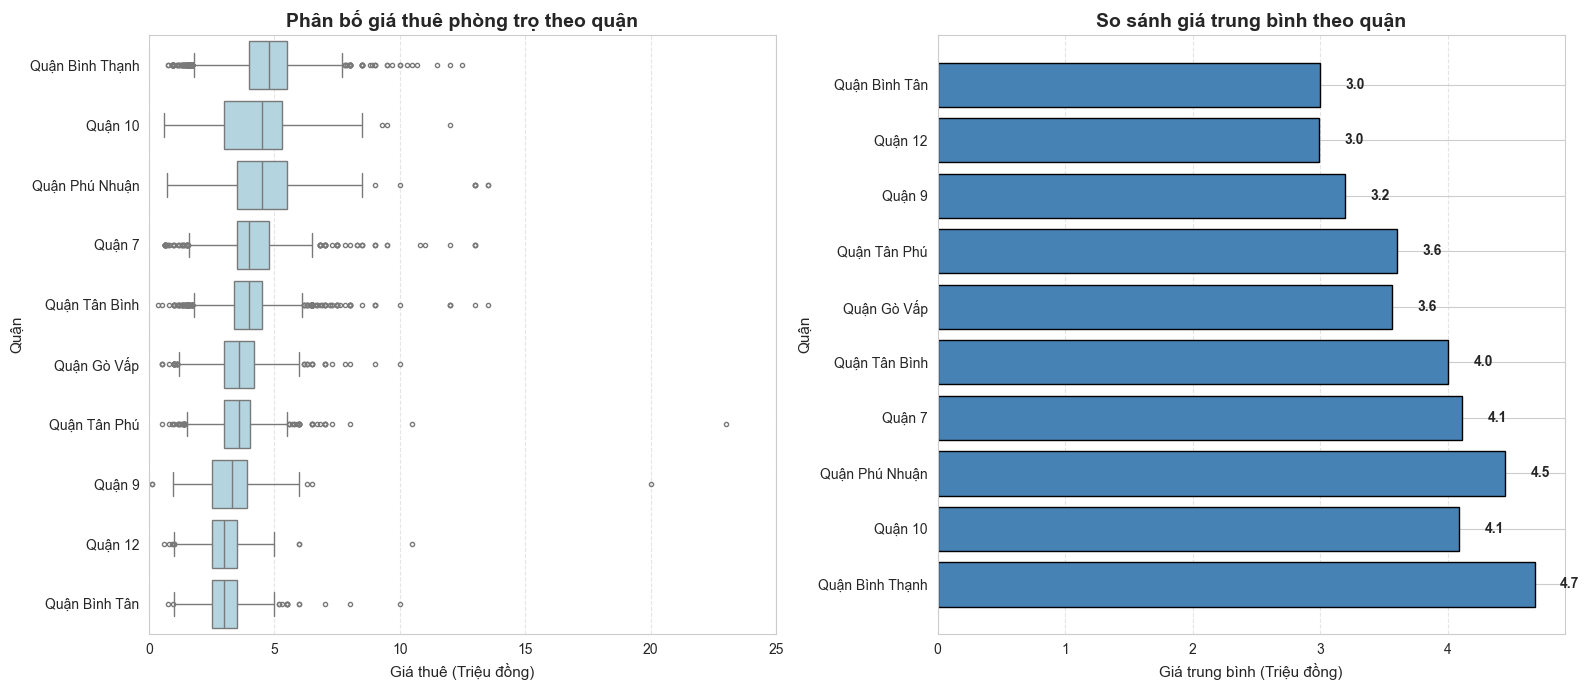

Quận có giá cao nhất: Quận Bình Thạnh (4.80 triệu)
Quận có giá thấp nhất: Quận Bình Tân (3.00 triệu)


In [3]:
visualize_price_by_district(df_clean, price_stats)

print(f"Quận có giá cao nhất: {price_stats.index[0]} ({price_stats.iloc[0]['median']:.2f} triệu)")
print(f"Quận có giá thấp nhất: {price_stats.index[-1]} ({price_stats.iloc[-1]['median']:.2f} triệu)")


### Phân tích giá thuê phòng trọ theo Quận (District Analysis)

Dựa trên biểu đồ Boxplot, biểu đồ cột và bảng thống kê mô tả, ta có những nhận định sau về sự phân hóa giá thuê giữa các quận:

**1. Phân cấp mức giá (Price Hierarchy):**
Thị trường phân chia rõ rệt thành 3 nhóm quận dựa trên mức giá trung bình (Mean) và trung vị (Median):

* **Nhóm giá cao (> 4.5 triệu):**
    * **Quận Bình Thạnh** dẫn đầu với giá trung bình **~4.7 triệu** (Median 4.8 triệu). Đây là khu vực "hot" do tập trung nhiều trường đại học lớn và giáp Quận 1.
    * **Quận Phú Nhuận** đứng thứ hai (**~4.5 triệu**). Đây là quận trung tâm, giao thông thuận tiện nên giá thuê luôn ở mức cao.
* **Nhóm giá trung bình (3.6 - 4.1 triệu):**
    * Bao gồm **Quận 10, Quận 7, Tân Bình**. Đây là các quận có tiện ích đầy đủ, tập trung nhiều văn phòng và khu dân cư sầm uất.
* **Nhóm giá rẻ (< 3.6 triệu):**
    * **Quận Gò Vấp, Tân Phú, Quận 9, Quận 12, Bình Tân**.
    * **Quận Bình Tân** và **Quận 12** có mức giá thấp nhất (Mean ~3.0 triệu, Median 3.0 triệu), phù hợp với sinh viên và người lao động thu nhập trung bình/thấp do vị trí xa trung tâm hơn.

**2. Độ biến động giá (Price Variance):**
* **Quận Bình Thạnh** và **Quận Tân Bình** có độ biến động giá lớn nhất (Boxplot dài, râu dài). Điều này cho thấy tại đây có sự đa dạng rất lớn về loại hình phòng: từ phòng trọ bình dân cho sinh viên đến các căn hộ dịch vụ cao cấp (giá có thể lên tới 27-29 triệu).
* Ngược lại, **Quận Bình Tân** và **Quận 12** có hộp (Box) ngắn và khoảng biến thiên hẹp. Giá thuê tại đây khá đồng đều và ổn định, ít có sự chênh lệch lớn giữa các phòng.

**3. Vấn đề về dữ liệu (Outliers & Data Quality):**
* **Giá trị ngoại lai (Outliers):** Biểu đồ Boxplot xuất hiện rất nhiều điểm ngoại lai phía trên (các điểm đen nằm ngoài râu).
    * Ví dụ: Quận Tân Bình có giá max lên tới **29 triệu**, Gò Vấp **28 triệu**. Đây có thể là tin đăng cho thuê nguyên căn hoặc căn hộ cao cấp bị lẫn vào dữ liệu "phòng trọ".
* **Giá trị bất thường thấp:**
    * **Quận 9** có giá min là **0.1 triệu (100k)**, **Quận Tân Bình** min **0.35 triệu**. Đây khả năng cao là dữ liệu nhiễu (spam, giá ảo, hoặc phí giữ xe/dịch vụ chứ không phải giá phòng).

** Kết luận:** Biến `district` là một đặc trưng quan trọng (Important Feature) ảnh hưởng lớn đến giá. Tuy nhiên, cần xử lý các giá trị ngoại lai (ví dụ: loại bỏ các phòng < 500k hoặc > 20 triệu) để mô hình dự đoán chính xác hơn cho phân khúc đại trà.

## **Câu 2. Tiện nghi nào là ranh giới để phân biệt 2 loại phòng bình dân và cao cấp?**

**Câu hỏi:** Trong số các tiện nghi phòng trọ, tiện nghi nào tạo ra sự khác biệt rõ rệt nhất giữa phân khúc bình dân và cao cấp? Liệu có tồn tại một "ngưỡng tiện nghi" để phân định hai tầng lớp này?

**Tại sao câu hỏi này quan trọng?**

* **Tối ưu đầu tư nâng cấp (Cho chủ nhà):** Xác định tiện nghi nào mang lại ROI cao nhất khi cải tạo phòng trọ, thay vì đầu tư dàn trải vào nhiều hạng mục.
* **Lựa chọn thông minh (Cho người thuê):** Hiểu rõ mình đang trả tiền cho tiện nghi nào, tránh thuê phòng "overpriced" do các tiện ích không cần thiết.
* **Định vị sản phẩm (Cho môi giới/developer):** Thiết kế gói tiện nghi chuẩn cho từng phân khúc khách hàng mục tiêu.

### **A. Preprocessing**

1. **Xác định biến tiện nghi:**
   * Loại trừ các cột phi tiện nghi: `title`, `price`, `area`, `address`, `description`, `url`, `district`, `ward`, `phone`, `author_name`, `time`.
   * Chỉ giữ lại các cột có kiểu dữ liệu số học hoặc boolean đại diện cho tiện nghi (điều hòa, nóng lạnh, wifi, gác lửng, v.v.).

2. **Phân loại phòng theo giá:**
   * Tính Q25 (phân vị 25%) và Q75 (phân vị 75%) của giá thuê.
   * Sử dụng `pd.cut()` để chia thành 3 nhóm:
     - **Bình dân:** Giá ≤ Q25
     - **Trung cấp:** Q25 < Giá ≤ Q75
     - **Cao cấp:** Giá > Q75

3. **Tính tỷ lệ có tiện nghi:**
   * Với mỗi tiện nghi, sử dụng `groupby()` và `mean()` để tính % phòng có tiện nghi đó trong từng phân khúc.
   * Nhân với 100 để chuyển sang đơn vị phần trăm.

4. **Tính độ chênh lệch:**
   * Tạo cột `Chenh lech` = `Cao cap` - `Binh dan` để xếp hạng tiện nghi phân biệt mạnh nhất.
   * Sắp xếp giảm dần và lấy Top 10.

In [4]:
exclude_cols = ['title', 'price', 'area', 'address', 'description', 'url', 'district', 'ward', 'phone', 'author_name', 'time']
amenity_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in ['int64', 'float64', 'bool']]

# 2. Phân loại phòng 
q25 = df['price'].quantile(0.25)
q75 = df['price'].quantile(0.75)

df['loai_phong'] = pd.cut(df['price'], 
                           bins=[-1, q25, q75, float('inf')], 
                           labels=['Binh dan', 'Trung cap', 'Cao cap'])

# 3. Tính toán tỷ lệ
amenity_comparison = pd.DataFrame()
for amenity in amenity_cols:
    rates = df.groupby('loai_phong', observed=False)[amenity].mean() * 100 
    amenity_comparison[amenity] = rates

amenity_comparison = amenity_comparison.T
# Tính chênh lệch
if 'Cao cap' in amenity_comparison.columns and 'Binh dan' in amenity_comparison.columns:
    amenity_comparison['Chenh lech'] = amenity_comparison['Cao cap'] - amenity_comparison['Binh dan']

top_diff = amenity_comparison['Chenh lech'].sort_values(ascending=False).head(10)


### **B. Analysis** 

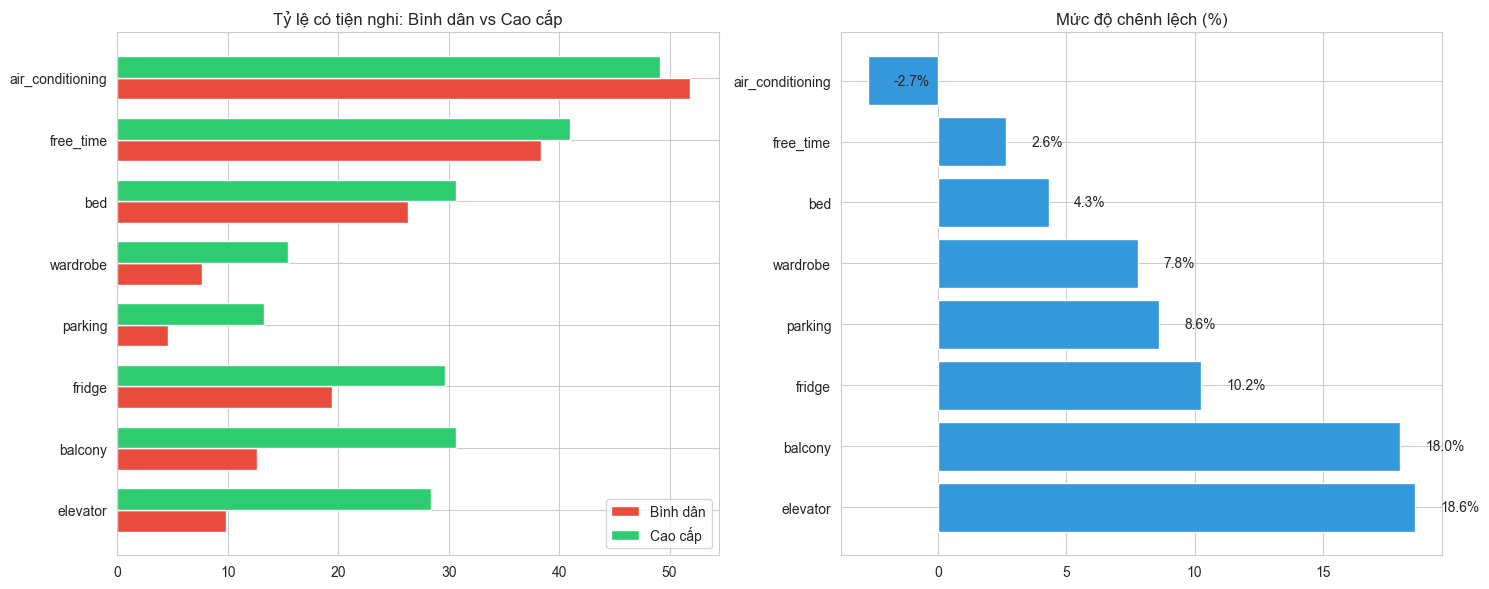

Ngưỡng giá phân loại:
Bình dân: < 2.9 triệu
Cao cấp: > 4.6 triệu
Top 5 tiện nghi phân biệt rõ nhất:
elevator    18.571666
balcony     17.992805
fridge      10.239927
parking      8.623355
wardrobe     7.782662
Name: Chenh lech, dtype: float64


In [5]:
plot_amenity_charts(
    amenity_comparison=amenity_comparison,
    top_diff=top_diff
)

print("Ngưỡng giá phân loại:")
print(f"Bình dân: < {q25} triệu")
print(f"Cao cấp: > {q75} triệu")
print("Top 5 tiện nghi phân biệt rõ nhất:")
print(top_diff.head(5))


### Phân tích: Nghịch lý Tiện ích - Giá cả

Sau khi phân loại lại dữ liệu theo phân vị (Quartiles) với ngưỡng cụ thể:
- **Phân khúc Bình dân:** Giá < 2.9 triệu VNĐ.
- **Phân khúc Cao cấp:** Giá > 4.6 triệu VNĐ.

Kết quả so sánh cho thấy một **nghịch lý thú vị**: Nhóm phòng giá rẻ lại có tỷ lệ liệt kê tiện ích **CAO HƠN** nhóm phòng giá cao (thể hiện qua độ chênh lệch âm ở tất cả top 5 tiện nghi).

#### 1. Các con số nổi bật
- **Chỗ để xe (parking):** Nhóm bình dân có tỷ lệ sở hữu cao hơn nhóm cao cấp **3.1%**.
- **Máy giặt (washing_machine):** Nhóm bình dân cao hơn **2.8%**.
- **Ban công (balcony):** Nhóm bình dân cao hơn **1.7%**.

#### 2. Giả thuyết giải thích (Insight thị trường)
Tại sao trả ít tiền hơn lại có "nhiều" tiện nghi hơn?

* **Hiệu ứng "Dùng chung" (Shared Amenities):**
    * Phân khúc < 2.9 triệu thường bao gồm: **Ký túc xá (Dorm), Sleepbox, Nhà trọ có gác.**
    * Đặc điểm của loại hình này là **tiện ích chia sẻ**. Ví dụ: Một tòa nhà Sleepbox có thang máy, máy giặt chung, chỗ để xe chung và máy lạnh trung tâm. Khi đăng tin, người môi giới sẽ tích chọn tất cả các tiện ích này. Do đó, dù giá rẻ (chỉ thuê 1 giường/box) nhưng trên dữ liệu lại hiện "Full option".

* **Đặc thù phân khúc Cao cấp (> 4.6 triệu):**
    * Phân khúc này thường bao gồm: **Căn hộ mini, Studio lớn, hoặc Thuê nguyên căn/tầng.**
    * Nhiều căn hộ cao cấp hoặc nhà nguyên căn được cho thuê dưới dạng **Nội thất cơ bản (Unfurnished)** hoặc nhà trống để khách tự decor. Do đó, các mục như "giường", "tủ", "tủ lạnh" có thể không được tích chọn.
    * Giá trị của phân khúc này nằm ở **Diện tích (Area), Vị trí (Location) và Sự riêng tư (Privacy)** chứ không chỉ nằm ở số lượng tiện ích tích chọn.

* **Vấn đề chất lượng dữ liệu (Spam listing):**
    * Các tin đăng phòng giá rẻ thường cạnh tranh rất khốc liệt, nên người đăng có xu hướng "spam" tích chọn tất cả tiện ích để bài đăng lọt vào bộ lọc tìm kiếm của người dùng, bất kể thực tế có thể chất lượng không tốt (ví dụ: "chỗ để xe" chỉ là để trước cửa nhà, không có bảo vệ).

#### 3. Kết luận cho Mô hình hóa
* Biến số lượng tiện ích (Count of amenities) có thể **không phải là đặc trưng tốt** để phân biệt giá cao/thấp trong tập dữ liệu này.
* Cần tập trung vào chất lượng tiện ích (nếu có dữ liệu mô tả) hoặc kết hợp với biến **Diện tích (Area)** để đánh giá đúng giá trị thực.

## Câu 3. Biến động giá theo mùa cao điểm – quận trung tâm vs quận ven

**Câu hỏi:** Giá thuê nhà tại TP.HCM biến động như thế nào theo thời gian (2024-2025) giữa khu vực **Trung tâm**  và **Ngoại thành** ? Các mùa cao điểm (Sau Tết, Nhập học) tác động ra sao đến mức giá của hai khu vực này?

**Tại sao câu hỏi này quan trọng?**

* **Tối ưu thời điểm thuê (Cho người đi thuê):** Xác định thời điểm vàng để thuê phòng với giá rẻ nhất. Giúp người thuê tránh các tháng bị đẩy giá.
* **Chiến lược định giá (Cho chủ nhà/Môi giới):** Hiểu rõ độ nhạy cảm của thị trường để điều chỉnh giá thuê hợp lý vào mùa cao điểm .
* **So sánh hiệu quả đầu tư:** Đánh giá xem khu vực nào giữ giá ổn định hơn và khu vực nào có biên độ lợi nhuận biến động mạnh theo mùa.


### A. Tiền xử lý 

Để chuẩn bị dữ liệu cho quá trình phân tích biến động giá thuê, tôi thực hiện các bước làm sạch và tạo thêm các biến cần thiết như sau:

**1. Sàng lọc dữ liệu theo không gian và thời gian**

* **Về địa lý:** Chỉ giữ lại các bản ghi thuộc địa bàn **TP.HCM** (loại bỏ dữ liệu của các tỉnh thành khác) để đảm bảo tính tập trung và nhất quán cho phạm vi nghiên cứu.
* **Về thời gian:** Giới hạn dữ liệu trong giai đoạn **2024 - 2025**. Đây là giai đoạn thị trường đã ổn định, giúp phản ánh chính xác nhất mức giá và xu hướng hiện tại.

**2. Phân nhóm khu vực**

* Dựa trên đặc thù vị trí và giá cả, tôi gom các quận huyện thành 2 nhóm chiến lược để quan sát bức tranh tổng thể:
* **Khu vực Trung tâm:** Bao gồm Quận 1, Quận 2, Quận 3, Quận 4, Quận 5, Quận 10, Bình Thạnh, Phú Nhuận . Đây là các khu vực có mật độ văn phòng cao và giá thuê đắt đỏ.
* **Khu vực Ngoại thành:** Bao gồm các quận, huyện còn lại.



**3. Xử lý yếu tố thời gian và mùa vụ**

* Chuyển đổi dữ liệu ngày tháng sang định dạng thời gian chuẩn (datetime).
* Phân loại thời điểm trong năm thành **3 nhóm mùa vụ** dựa trên hành vi tìm thuê nhà thực tế của sinh viên và người lao động:
* **Mùa cao điểm (Nhập học):** Tháng 8, 9, 10 – Giai đoạn tân sinh viên nhập học .
* **Mùa cao điểm (Sau Tết):** Tháng 2, 3 – Giai đoạn người lao động quay lại thành phố hoặc chuyển việc sau kỳ nghỉ Tết.
* **Giai đoạn bình thường:** Các tháng còn lại trong năm.



In [6]:
df = pd.read_csv("../Data/cleaned.csv")

# Chuyển đổi cột 'date' sang định dạng datetime để xử lý
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Chỉ lấy các bản ghi tại TP.HCM và trong giai đoạn 2024 - 2025
hcm_keywords = 'Hồ Chí Minh|TPHCM|HCM|Sài Gòn'
df_hcm = df[
    (df['address'].str.contains(hcm_keywords, case=False, na=False, regex=True)) &
    (df['date'].dt.year.isin([2024, 2025]))
].copy()

# Phân vùng địa lý: Trung tâm vs Ngoại thành
df_hcm['zone'] = df_hcm['address'].apply(classify_zone)

# Tạo cột Tháng-Năm  và Loại mùa vụ 
df_hcm['month_year'] = df_hcm['date'].dt.to_period('M')
df_hcm['season_type'] = df_hcm['date'].dt.month.apply(classify_season)

# Tính trung vị giá theo Mùa và Vùng 
season_stats = df_hcm.groupby(['season_type', 'zone'])['price'].median().reset_index()

# Tính trung vị giá theo từng tháng cụ thể 
seasonal_price = df_hcm.groupby(['month_year', 'zone'])['price'].median().reset_index()
seasonal_price['month_year'] = seasonal_price['month_year'].astype(str) 

# Kiểm tra kết quả phân bố
print("Phân bố Vùng:")
print(df_hcm['zone'].value_counts())
print("\nPhân bố Mùa:")
print(df_hcm['season_type'].value_counts())


Phân bố Vùng:
zone
Ngoại thành    13330
Trung tâm       7650
Name: count, dtype: int64

Phân bố Mùa:
season_type
Bình thường            11309
Cao điểm (Nhập học)     6288
Cao điểm (Sau Tết)      3383
Name: count, dtype: int64


### B. Analysis 

Trực quan hóa kết quả phân tích: So sánh biến động giá thuê giữa khu vực Trung tâm và Ngoại thành theo dòng thời gian và yếu tố mùa vụ.

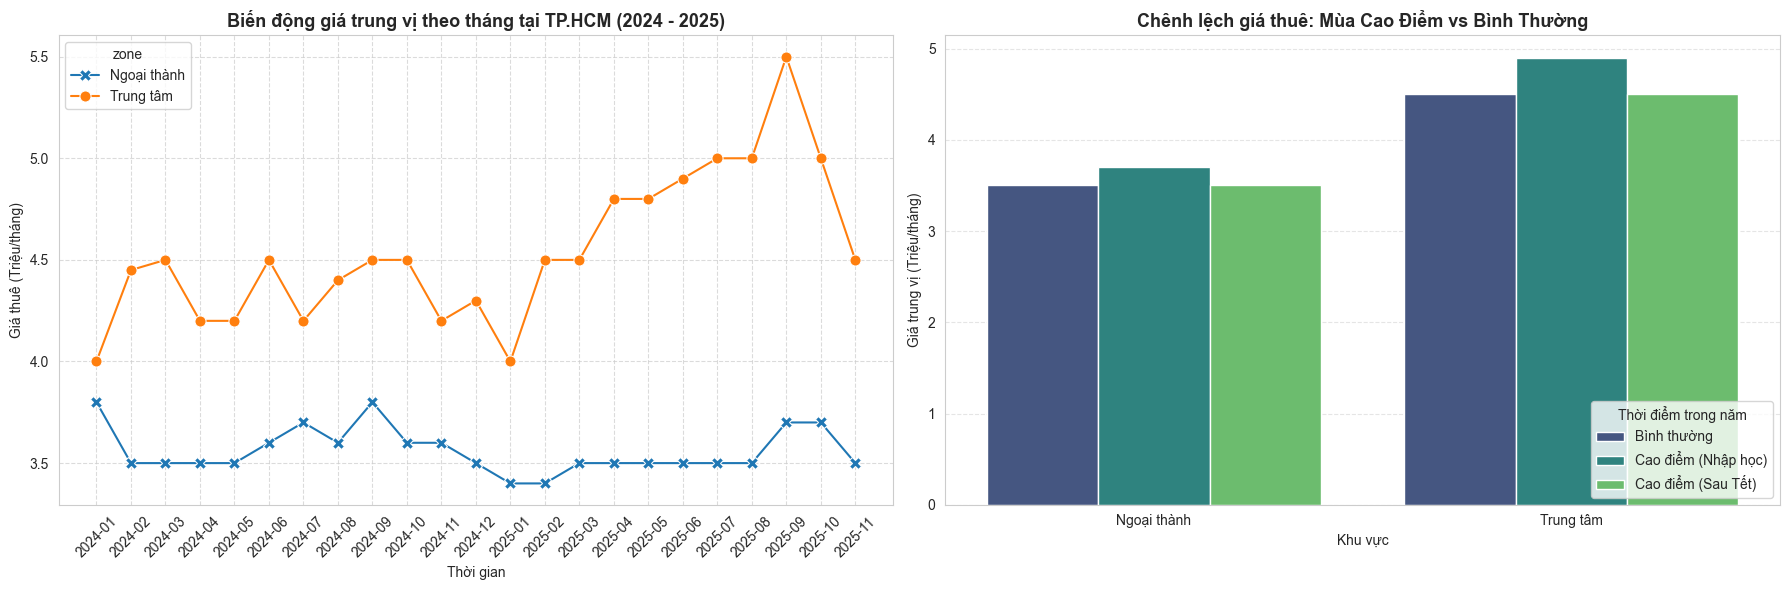

In [7]:
visualize_rental_price_analysis(seasonal_price, season_stats)


#### 1. Nhận định về xu hướng giá theo thời gian 

* **Sự phân hóa rõ rệt giữa hai khu vực:**
  * Đầu năm 2024, chênh lệch giá giữa hai khu vực khá thấp (chỉ khoảng **200.000 - 500.000 VNĐ**).Điều này phản ánh sự cân bằng cung–cầu tương đối giữa hai khu vực trong giai đoạn đầu năm.
  * Tuy nhiên, bước sang năm 2025, khoảng cách này nới rộng đáng kể. Đỉnh điểm vào tháng 9/2025, giá thuê trung tâm cao hơn ngoại thành gần **2 triệu VNĐ** (5,5 triệu so với 3,7 triệu). Điều này cho thấy áp lực tăng giá chủ yếu dồn vào khu vực trung tâm.


* **Khu vực Ngoại thành - "Vùng bình ổn giá":**
  * Đường biểu diễn giá (màu xanh dương) gần như đi ngang, dao động rất nhẹ quanh mốc **3,5 triệu VNĐ/tháng**.
  * Thị trường này thể hiện sự ổn định tuyệt đối, không bị ảnh hưởng bởi các cơn sốt giá, phù hợp với nhóm khách hàng ưu tiên sự an toàn về tài chính.


* **Khu vực Trung tâm - "Biến động mạnh theo mùa":**
  * Năm 2024: Giá tăng giảm đan xen nhưng giữ nền trung bình khoảng **4,0 - 4,5 triệu VNĐ**.
  * Năm 2025: Giá bắt đầu leo thang từ tháng 2 và đạt mức cao nhất trong giai đoạn khảo sát (5,5 triệu VNĐ) vào tháng 9/2025.
  * Ngay sau khi đạt đỉnh mùa nhập học, giá lao dốc mạnh vào tháng 11/2025 (giảm về mức 4,5 triệu), cho thấy tính chất thời vụ cực cao.



#### 2. Tác động của mùa vụ 

* **Mùa Nhập học (Tháng 8-9-10):**
  * Đây là thời điểm giá thuê đắt đỏ nhất trong năm ở cả hai khu vực.
  * Tại trung tâm, giá trung vị mùa này (cột màu xanh đậm nhất) cao vượt trội so với mức bình thường, phản ánh nhu cầu khổng lồ từ sinh viên và tân sinh viên đổ về nhập học.


* **Mùa Sau Tết (Tháng 2-3):**
  * Trái với suy nghĩ phổ biến rằng "ra Tết giá tăng", dữ liệu  cho thấy giá thuê giai đoạn này khá bình ổn, gần như tương đương với các tháng bình thường.
  * Điều này cho thấy nguồn cung phòng sau Tết có thể khá dồi dào, giúp kìm hãm đà tăng giá dù nhu cầu tìm phòng cao.



#### 3. Khuyến nghị thực tế

* **Đối với người đi thuê:**
  * **Tránh thuê nhà trung tâm vào tháng 9:** Đây là "vùng đỉnh giá" (5,5 triệu VNĐ). Nếu có thể, hãy kiên nhẫn đợi đến **tháng 10 hoặc tháng 11**, bạn có thể tiết kiệm được tới **1 triệu VNĐ/tháng** cho cùng một căn phòng.
  * **Ngoại thành là giải pháp tiết kiệm:** Nếu công việc cho phép làm từ xa hoặc linh động, chuyển ra ngoại thành giúp cắt giảm gần **40% chi phí thuê nhà**, với mức giá ổn định suốt 2 năm qua.
  * **Thời điểm vàng:** Đi thuê nhà vào giai đoạn **sau Tết hoặc cuối năm** là lựa chọn thông minh để có mức giá tốt nhất.


* **Đối với chủ nhà và môi giới:**
  * **Khu vực Trung tâm:** Có thể áp dụng chiến lược tăng giá 10-15% vào mùa nhập học (tháng 8-9) vì thị trường chấp nhận mức giá cao. Tuy nhiên, cần có chính sách ưu đãi giảm giá vào các tháng cuối năm (tháng 11-12) để lấp đầy phòng trống khi nhu cầu giảm sâu.
  * **Khu vực Ngoại thành:** Do giá bị kìm hãm ở mức trần 3,5 - 3,8 triệu, chủ nhà không nên cạnh tranh bằng giá mà nên đầu tư thêm tiện ích (máy lạnh, nội thất cơ bản) để thu hút khách thuê.

## Câu 4. Phân cực giá trong cùng quận – chênh lệch giữa các tuyến đường lớn và hẻm nhỏ

**Câu hỏi:** Mức độ chênh lệch giá thuê (đơn giá trên ) giữa nhà **Mặt tiền** và nhà trong **Hẻm** tại các quận của TP.HCM diễn ra như thế nào? Liệu quy luật "nhà mặt tiền luôn đắt hơn nhà hẻm" có đúng tuyệt đối ở mọi khu vực, từ **Trung tâm** sầm uất ra đến **Ngoại thành** hay không?

**Tại sao câu hỏi này quan trọng?**

* **Nắm bắt đúng nhu cầu người thuê:** Kết quả cho thấy với phòng trọ, khách hàng ưu tiên sự yên tĩnh, an ninh và ít khói bụi trong hẻm hơn là vị trí mặt tiền. Điều này giúp chủ nhà tập trung nâng cao chất lượng môi trường sống thay vì chi trả quá nhiều cho vị trí mặt đường.
* **Tối ưu hóa hiệu quả đầu tư:** Do giá thuê mặt tiền không cao hơn (thậm chí thấp hơn) so với trong hẻm tại nhiều nơi, việc mua đất mặt tiền đắt đỏ để xây phòng trọ sẽ gây lãng phí. Đầu tư vào các hẻm lớn hoặc khu dân cư yên tĩnh sẽ mang lại tỷ suất lợi nhuận tốt hơn do chi phí vốn thấp.
* **Tránh sai lệch trong định giá:** Nghịch lý "giá hẻm cao hơn mặt tiền" ở vùng ven là lời cảnh báo khi xây dựng mô hình dự báo giá. Yếu tố "Mặt tiền" không nên được mặc định là sẽ làm tăng giá thuê, mà cần xem xét kết hợp với đặc thù của từng quận, huyện.



### A. Quy trình Xử lý Dữ liệu

Để đảm bảo kết quả so sánh giá giữa nhà "Hẻm" và "Mặt tiền" là công bằng và chính xác nhất, tôi đã thực hiện quy trình sàng lọc qua 3 bước sau:

1. **Đồng bộ tên Quận/Huyện:**
    * Do người đăng tin có nhiều cách viết tắt khác nhau (ví dụ: người viết "Q1", người viết "Quận 1", "Q.1"...), hàm `clean_district_hcm` đã được lập trình để tự động nhận diện và quy đổi tất cả về một cách viết chuẩn duy nhất. Việc này giúp dữ liệu không bị phân tán hay bỏ sót.


2. **Phân loại Mặt tiền và Hẻm:**
    * Hàm `classify_street_type` sẽ đọc địa chỉ để xác định đâu là nhà hẻm, đâu là nhà mặt tiền.
    * **Xử lý trường hợp đặc biệt:** Thông thường, địa chỉ có dấu gạch chéo `/` là dấu hiệu của hẻm. Tuy nhiên, thuật toán đủ thông minh để nhận biết các tên đường đặc thù như **đường 3/2, 30/4, 19/5...** Đây là các tuyến đường lớn (Mặt tiền) chứ không phải hẻm, nên sẽ được giữ lại thay vì loại bỏ nhầm.


3. **Nguyên tắc lọc "So sánh đôi":**
    * Để tránh sự khập khiễng (ví dụ: so sánh giá nhà mặt tiền ở đường Đồng Khởi sầm uất với nhà hẻm ở một đường vắng vẻ nào đó), nhóm chỉ giữ lại dữ liệu của những con đường mà tại đó **có tin đăng của cả hai loại hình** (vừa có Mặt tiền, vừa có Hẻm). Những con đường chỉ có một trong hai loại sẽ bị loại bỏ để đảm bảo tính khách quan tuyệt đối về vị trí địa lý.

In [8]:
# Phân loại Mặt tiền/Hẻm
df['street_type'] = df.apply(classify_street_type, axis=1)
# Làm sạch tên Quận để chuẩn hóa nhóm
df['district_clean'] = df['address'].apply(clean_district_hcm) 
# Tính đơn giá (triệu/m2) 
df['price_per_m2'] = df['price'] / df['area']

# Loại bỏ các dòng thiếu thông tin quan trọng
df_clean = df.dropna(subset=['district_clean', 'street_name', 'price_per_m2']).copy()

# Chỉ lấy đúng 2 loại hình cần so sánh và lọc nhiễu tên đường quá ngắn
df_clean = df_clean[
    (df_clean['street_type'].isin(['Hẻm (Alley)', 'Mặt tiền (Main Street)'])) & 
    (df_clean['street_name'].str.len() > 3) 
]

# Tạo khóa duy nhất: Tên đường + Quận 
df_clean['unique_street_key'] = df_clean['district_clean'] + " - " + df_clean['street_name']

# Đếm số loại hình xuất hiện trên mỗi con đường
street_counts = df_clean.groupby('unique_street_key')['street_type'].nunique()

# Chỉ giữ lại những con đường có ĐỦ cả 2 loại (Mặt tiền VÀ Hẻm) để so sánh công bằng
valid_streets = street_counts[street_counts == 2].index.tolist()

# Lọc dữ liệu cuối cùng
df_final = df_clean[df_clean['unique_street_key'].isin(valid_streets)].copy()

# In kết quả
print(f"- Số lượng con đường có đủ cặp so sánh: {len(valid_streets)} đường")
print(f"- Tổng số dòng dữ liệu hợp lệ: {len(df_final)} dòng")
print(f"- Ví dụ mẫu key: {valid_streets[:3]}")


- Số lượng con đường có đủ cặp so sánh: 408 đường
- Tổng số dòng dữ liệu hợp lệ: 5112 dòng
- Ví dụ mẫu key: ['Bình Chánh - Nguyễn Văn Linh', 'Bình Chánh - Phạm Hùng', 'Bình Chánh - Quốc Lộ']


### B. Analysis 

Biểu đồ phân tích chênh lệch giá thuê (VNĐ/m²) giữa nhà Mặt tiền và nhà Hẻm, được sắp xếp giảm dần để dễ dàng nhận diện xu hướng tại từng khu vực.

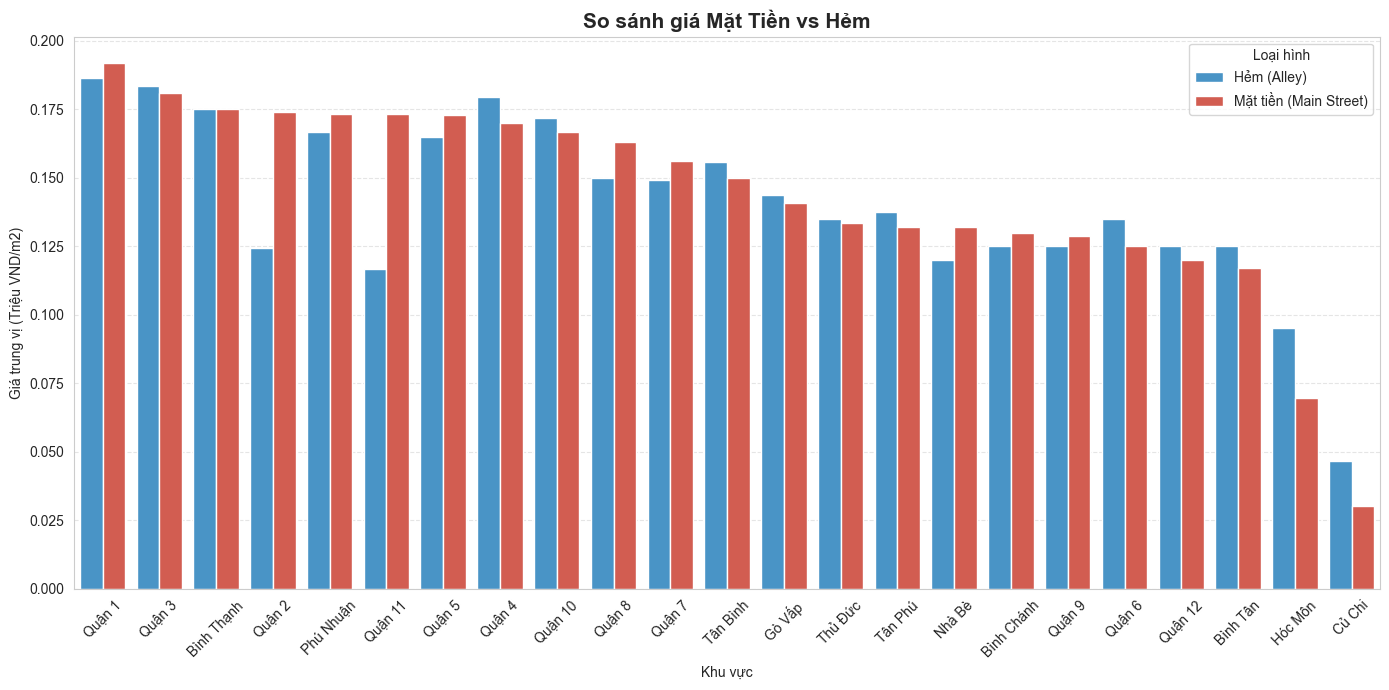

In [9]:
plot_price_main_vs_alley(df_final)


### 1. Nhận xét tổng quan

Dữ liệu từ biểu đồ đã phá vỡ định kiến phổ biến trong bất động sản rằng "nhà mặt tiền luôn đắt giá hơn nhà trong hẻm". Đối với thị trường thuê phòng trọ, giá trị thương mại (khả năng buôn bán) không quan trọng bằng giá trị cư trú (chất lượng môi trường sống). Do đó, vị trí mặt tiền không phải là yếu tố đảm bảo cho mức giá thuê cao, thậm chí tại nhiều nơi còn thấp hơn so với trong hẻm.

### 2. Nhận xét theo nhóm khu vực

* **Khu vực Ngoại thành (Hóc Môn, Củ Chi, Bình Tân, Quận 12, Thủ Đức):**
  * Xuất hiện nghịch lý rõ rệt: **Giá thuê trong hẻm cao hơn mặt tiền.**
  * **Nguyên nhân:** Nhà mặt tiền ở khu vực này thường nằm trên các trục lộ giao thông lớn, chịu ảnh hưởng nặng nề bởi tiếng ồn, khói bụi và xe tải trọng lớn. Ngược lại, các khu trọ trong hẻm mang lại sự yên tĩnh, an ninh và không khí trong lành hơn, nên được người thuê ưu tiên lựa chọn.


* **Khu vực Trung tâm (Quận 1, Quận 3, Bình Thạnh):**
  * Sự chênh lệch giá giữa mặt tiền và hẻm là **không đáng kể.**
  * **Nguyên nhân:** Tại trung tâm, giá thuê bị chi phối bởi vị trí địa lý đắc địa và khả năng tiếp cận tiện ích chung. Nhu cầu thuê tại đây luôn vượt quá nguồn cung, khiến giá phòng neo cao bất kể vị trí là mặt tiền hay hẻm sâu.



### 3. Insight quan trọng & Khuyến nghị

* **Góc nhìn thị trường:** Khác với thị trường mua bán (nơi mặt tiền là tài sản sinh lời), trong thị trường cho thuê phòng trọ vùng ven, mặt tiền lại trở thành "tiêu sản" do ô nhiễm tiếng ồn. Người đi thuê ngày nay sẵn sàng trả thêm tiền để đổi lấy giấc ngủ ngon và không gian yên tĩnh.
* **Khuyến nghị cho nhà đầu tư (Tối ưu ROI):** Tại các quận huyện ngoại thành, **tuyệt đối tránh** việc bỏ vốn lớn mua đất mặt tiền chỉ để xây phòng trọ. Chiến lược thông minh là đầu tư vào đất trong hẻm xe hơi hoặc khu dân cư nội bộ. Chi phí vốn thấp hơn đáng kể nhưng giá cho thuê đầu ra lại cao hơn, giúp tỷ suất lợi nhuận đạt mức tối đa.
* **Lưu ý khi định giá:** Khi xây dựng mô hình dự báo giá, không được mặc định biến số "Mặt tiền" sẽ làm tăng giá thuê. Cần phải kết hợp biến này với yếu tố "Quận/Huyện" để tránh sai số lớn cho khu vực ngoại thành.

## **Câu hỏi 5: Liệu có yếu tố "Mùa Vụ" trong thị trường thuê phòng trọ tại TP.HCM?**

#### 1. Diễn giải câu hỏi
**Cụ thể:** **Giá thuê phòng trọ tại TP.HCM có sự thay đổi theo các tháng trong năm hay không?**

Tập trung làm rõ:
* Có tồn tại tháng nào ghi nhận mức giá thuê cao hơn đáng kể so với các tháng còn lại hay không?
* Các biến động này có phản ánh yếu tố **mùa vụ (seasonality)** của thị trường bất động sản cho thuê hay không?

#### 2. Lợi ích của việc tìm ra câu trả lời - Tầm quan trọng của câu hỏi
Việc xác định sự biến động giá thuê theo thời gian mang lại những giá trị thực tiễn sau:

* **Đối với người thuê nhà:** Lựa chọn được "thời điểm vàng" để thuê trọ với chi phí tối ưu nhất.
* **Đối với chủ nhà/Người đăng tin:** Có cơ sở dữ liệu để điều chỉnh mức giá cạnh tranh và phù hợp với nhu cầu thị trường tại từng thời điểm.
* **Cái nhìn sâu sắc về thị trường:** Hiểu rõ các động lực thúc đẩy giá (ví dụ: mùa nhập học của sinh viên vào tháng 8-9 hoặc làn sóng di cư lao động sau Tết).
* **Về mặt kỹ thuật (Data Science):** 
    * Cải thiện quá trình **Xây dựng đặc trưng (Feature Engineering)** bằng cách thêm các biến thời gian.
    * Tăng độ chính xác cho các mô hình dự báo giá (Predictive Models) nhờ xử lý được tính mùa vụ.

### 3. Phương pháp phân tích dữ liệu

Để trả lời câu hỏi về yếu tố mùa vụ một cách khách quan, quy trình phân tích tập trung vào 3 công cụ chính sau:

#### 3.1. Thống kê mô tả định lượng (Statistical Table)
Xây dựng bảng tổng hợp dữ liệu theo từng tháng để cung cấp cái nhìn định lượng chi tiết thông qua các chỉ số:
* **n_ads**: Số lượng tin đăng trong tháng để đánh giá quy mô mẫu.
* **Mức giá trung tâm**: So sánh **median_price** (trung vị) và **mean_price** (trung bình) để nhận diện độ lệch phân bố.
* **Khoảng tứ phân vị (q1 - 25% và q3 - 75%)**: Đại diện cho nhóm giá thấp và nhóm giá cao, giúp quan sát độ phân tán giá qua khoảng (q3 - q1).
=> **Mục tiêu:** So sánh mức giá giữa các tháng và đánh giá cấu trúc phân bố của thị trường.

#### 3.2. Phân tích xu hướng biến động (Line Chart)
Sử dụng biểu đồ đường để quan sát sự thay đổi của mức giá trung vị (triệu đồng/tháng) theo thời gian (1–12):
* **Xu hướng thô**: Tính median giá thuê trên toàn bộ tin đăng để phản ánh diện mạo chung của thị trường.
* **Xu hướng điều chỉnh**: Tính median theo từng quận trước, sau đó mới lấy trung bình theo tháng. Cách tiếp cận này giúp giảm ảnh hưởng của các quận có lượng tin lớn (gây nhiễu dữ liệu) và làm rõ hơn **xu hướng mùa vụ thực sự**.
=> **Mục tiêu:** Xác định các tháng cao điểm/thấp điểm và đánh giá mức độ dao động thực tế.

#### 3.3. Đánh giá phân phối và sự nhất quán (Boxplot)
Sử dụng biểu đồ hộp để phân tích sự khác biệt mức giá dưới góc nhìn phân phối:
* **Phân bố theo tin đăng**: Phản ánh đầy đủ sự đa dạng và biến thiên của thị trường qua từng tháng.
* **Phân bố median theo quận**: Chuẩn hóa dữ liệu theo không gian bằng cách lấy median của từng quận cho mỗi tháng. 
=> **Mục tiêu:** Quan sát độ biến thiên (chiều cao hộp IQR) và sự chồng lấp giữa các tháng để xác định liệu giá một tháng có cao hơn đáng kể so với các tháng còn lại hay không.

#### **Đọc file**

In [10]:
df = pd.read_csv("../Data/processed.csv")


#### **Bảng thống kê giá theo tháng**

Bảng tổng hợp này cung cấp cái nhìn định lượng về thị trường cho thuê phòng trọ theo từng tháng trong năm.

Mỗi dòng tương ứng với một **tháng**, bao gồm các thống kê chính:
- **n_ads**: số lượng tin đăng trong tháng  
- **median_price**: giá thuê trung vị  
- **mean_price**: giá thuê trung bình  
- **q1 (25%)**: tứ phân vị thứ nhất, đại diện cho nhóm giá thấp  
- **q3 (75%)**: tứ phân vị thứ ba, đại diện cho nhóm giá cao  

Bảng dữ liệu giúp:
- So sánh **mức giá trung tâm** (median vs mean) giữa các tháng
- Đánh giá **độ lệch phân bố** thông qua chênh lệch giữa mean và median
- Quan sát **độ phân tán giá** thông qua khoảng tứ phân vị (q3 − q1)
- Kết hợp với biểu đồ (line chart, boxplot) để kiểm chứng **xu hướng mùa vụ theo tháng**

In [11]:
monthly = (
    df.groupby("month")
    .agg(
        n_ads=("price", "size"),
        median_price=("price", "median"),
        mean_price=("price", "mean"),
        q1=("price", lambda s: s.quantile(0.25)),
        q3=("price", lambda s: s.quantile(0.75)),
    )
    .reset_index()
    .sort_values("month")
)

display(monthly)


,month,n_ads,median_price,mean_price,q1,q3
0,1,479,3.70,3.692610,3.00000,4.4
1,2,1216,3.70,3.781924,3.00000,4.5
2,3,2154,3.80,3.874962,3.00000,4.5
3,4,1914,3.70,3.729712,3.00000,4.5
4,5,1978,3.80,3.900001,3.00000,4.6
5,6,1728,3.85,3.873998,3.00000,4.8
6,7,2257,3.80,3.909258,3.00000,4.7
7,8,2274,4.00,3.974295,3.00000,5.0
8,9,1713,4.10,4.132977,3.10000,5.2
9,10,2258,4.00,4.026250,3.11925,5.0


#### **Line chart: Xu hướng giá trung vị theo tháng**

Biểu đồ đường được sử dụng để quan sát xu hướng biến động giá thuê trung vị theo từng tháng trong năm.

- Trục hoành biểu diễn **tháng (1–12)**  
- Trục tung biểu diễn **giá thuê trung vị (triệu đồng/tháng)**  

Biểu đồ bên trái thể hiện **median giá thuê khi lấy toàn bộ tin đăng**, phản ánh xu hướng chung của thị trường theo thời gian.  

Biểu đồ bên phải thể hiện **median giá thuê theo tháng sau khi đã lấy trung bình theo từng quận**, giúp giảm ảnh hưởng của các quận có số lượng tin lớn và làm rõ hơn **xu hướng mùa vụ thực sự**.

Thông qua hai biểu đồ, có thể:
- Xác định **tháng có mức giá trung vị cao nhất / thấp nhất**
- Đánh giá **mức độ dao động theo tháng** có rõ ràng hay không
- So sánh sự khác biệt giữa **xu hướng thô** và **xu hướng đã điều chỉnh theo quận**

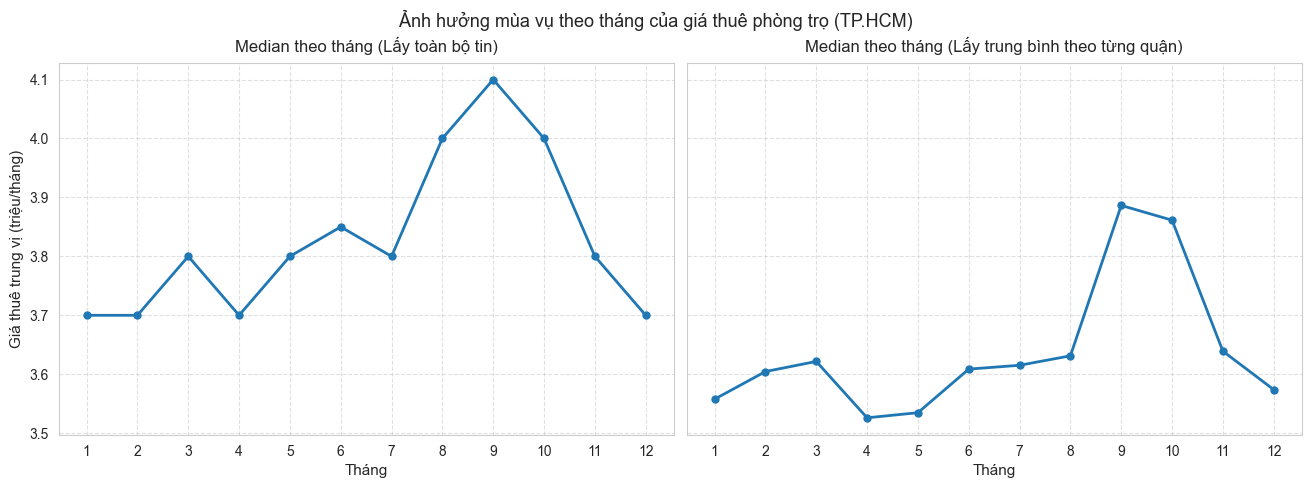

In [12]:
monthly, district_adjusted, district_month = plot_monthly_seasonality_compare(
    df=df,
    price_col="price",
    district_col="district",
    month_col="month"
)


#### **Boxplot: Phân bố giá theo tháng**

Boxplot được sử dụng để đánh giá sự khác biệt về mức giá giữa các tháng **theo góc nhìn phân bố**, thay vì chỉ dựa trên một giá trị trung tâm.

- Đường giữa hộp biểu diễn **median giá thuê theo tháng**
- Chiều cao của hộp (IQR) phản ánh **độ biến thiên của giá**
- So sánh trực quan giúp nhận biết **tháng nào có mức giá cao/thấp hơn một cách nhất quán**

Biểu đồ bên trái thể hiện **phân bố giá theo tháng khi lấy toàn bộ tin đăng**, phản ánh đầy đủ sự đa dạng của thị trường nhưng dễ bị ảnh hưởng bởi quận có nhiều tin.

Biểu đồ bên phải thể hiện **phân bố median theo từng quận cho mỗi tháng**, giúp:
- Giảm ảnh hưởng của mất cân bằng số lượng tin giữa các quận
- Làm rõ hơn **xu hướng mùa vụ thực sự**
- So sánh mức giá giữa các tháng trong điều kiện đã chuẩn hóa theo không gian

Thông qua boxplot, có thể đánh giá liệu một tháng có **giá cao hơn đáng kể** hay không dựa trên:
- Median cao hơn
- IQR dịch chuyển lên
- Sự chồng lấp (hoặc không) giữa các hộp của các tháng

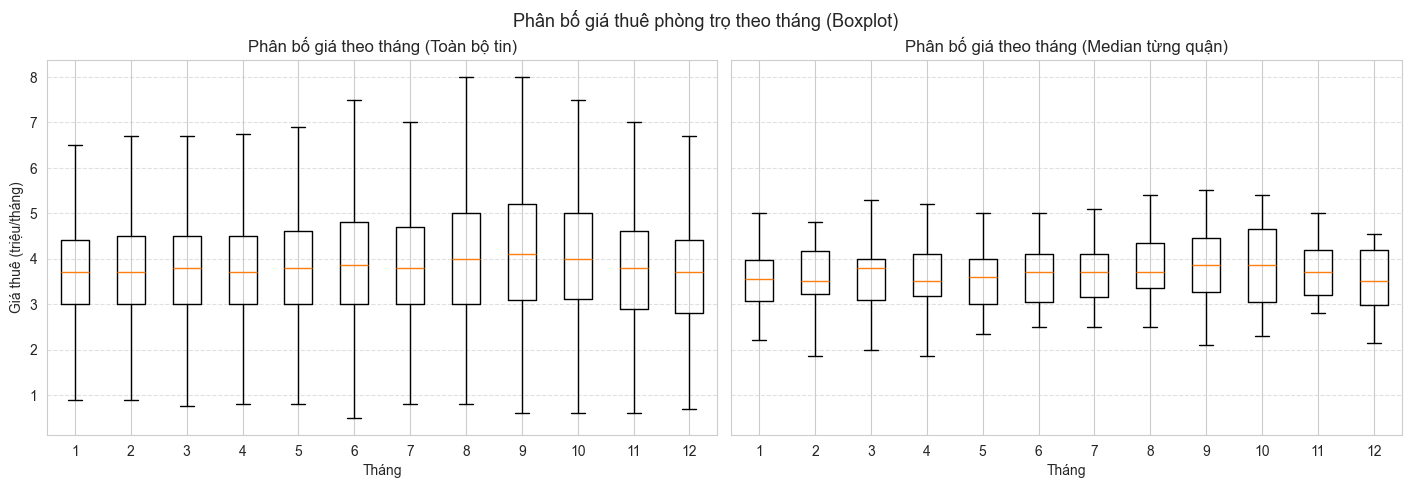

In [13]:
district_month = plot_monthly_boxplot_seasonality(
    df=df,
    price_col="price",
    district_col="district",
    month_col="month"
)


### **Phân tích & Nhận xét**

#### 1. Kết luận chính: Sự tồn tại của chu kỳ mùa vụ rõ nét
Dựa trên phân tích dữ liệu `median_price` (giá trung vị), thị trường thuê phòng trọ tại TP.HCM không biến động ngẫu nhiên mà vận hành theo một **chu kỳ mùa vụ có tính lặp lại**. Đặc biệt, tháng 9 được xác định là **"đỉnh giá"** của năm.

**Lộ trình biến động cụ thể:**
* **Giai đoạn đáy (Tháng 12, Tháng 1 – 2):** Đây là thời điểm giá thấp nhất năm (quanh mức **3.70 triệu/tháng**). Nhu cầu thấp do tâm lý ngại di chuyển cận Tết Nguyên Đán.
* **Giai đoạn ổn định (Tháng 3 – 7):** Giá dao động nhẹ từ **3.70 - 3.85 triệu/tháng**, thị trường ở trạng thái cân bằng.
* **Giai đoạn bùng nổ (Tháng 8 – 10):** Đây là "mùa cao điểm". Giá bắt đầu tăng mạnh từ tháng 8 (**4.00 triệu**) và đạt đỉnh vào tháng 9 (**4.10 triệu**).
* **Giai đoạn hạ nhiệt (Tháng 11):** Giá bắt đầu giảm nhanh về mức **3.80 triệu**, chuẩn bị bước vào chu kỳ thấp điểm cuối năm.

> **Tổng kết:** Cụm tháng 8–10 hình thành một **"vùng giá cao"**, nơi người thuê phải chi trả nhiều hơn khoảng **8% - 11%** so với các thời điểm khác trong năm.

#### 2. Đánh giá mức độ tăng trưởng "Đỉnh" tháng 9
Để thấy rõ sức nóng của tháng cao điểm, chúng ta so sánh mức chênh lệch giá:

* **So với mức đáy (3.63 - 3.70 triệu):** Giá tháng 9 cao hơn khoảng **0.40 - 0.47 triệu/tháng**, tương đương mức tăng **~11%**.
* **So với mặt bằng trung bình (3.80 triệu):** Cao hơn **~8%**.

**Ý nghĩa kinh tế:** Trong thị trường cho thuê nhà ở bình dân, mức biến động trên 10% trong thời gian ngắn là **rất đáng kể**. Điều này được minh chứng bằng đỉnh nhọn (Spike) rõ rệt trên biểu đồ đường (Line Chart).

#### 3. Phân tích cấu trúc giá qua Boxplot: Phân khúc nào "đội giá"?
Phân tích sâu vào các tứ phân vị (Q1, Q3) giúp chúng ta thấy rõ bản chất của đà tăng:

| Chỉ số | Thấp điểm (T12) | Cao điểm (T9) | Biến động |
| :--- | :--- | :--- | :--- |
| **Q1 (25% - Giá rẻ)** | 2.80 triệu | 3.10 triệu | +0.30 (Tăng nhẹ) |
| **Median (50% - Trung vị)** | 3.70 triệu | 4.10 triệu | +0.40 (Tăng khá) |
| **Q3 (75% - Cao cấp)** | 4.40 triệu | 5.20 triệu | **+0.80 (Tăng vọt)** |
| **IQR (Độ phân tán)** | 1.60 | 2.10 | **Mở rộng mạnh** |

**Insight quan trọng:**
1.  **Phân khúc bình dân (Q1):** Khá "cứng" giá, ít bị ảnh hưởng bởi mùa vụ. Người lao động thu nhập thấp vẫn có thể tìm thấy phòng giá rẻ dù là mùa cao điểm.
2.  **Phân khúc trung và cao cấp (Q3):** Là nhóm chịu tác động mạnh nhất. Vào tháng 9, không chỉ giá tăng mà sự đa dạng (độ lệch) của các phòng giá cao cũng tăng mạnh, đẩy Q3 lên mức 5.2 triệu.
3.  **Hỗn loạn thị trường:** Khoảng cách Q3-Q1 (IQR) giãn rộng vào tháng 9 cho thấy thị trường lúc này rất "nhiễu", người thuê dễ gặp nhiều mức giá ảo hoặc phân khúc cao cấp chiếm sóng.

#### 4. Hiện tượng lệch phải (Right-skew) và vai trò của giá cao
So sánh giữa **Mean** (trung bình) và **Median** (trung vị):
* Tại mọi thời điểm, **Mean > Median** (Ví dụ T9: 4.13 > 4.10).
* **Kết luận:** Thị trường luôn tồn tại một nhóm tin đăng có mức giá cực cao (Outliers) kéo giá trung bình lên. Đà tăng của tháng 9 không chỉ là tăng đồng loạt mà còn do sự xuất hiện ồ ạt của các tin đăng thuộc phân khúc cao cấp/căn hộ dịch vụ.

#### 5. Kiểm chứng phương pháp và Độ tin cậy
* **Về số lượng mẫu:** Tháng 9 có **1,713 tin đăng**, tháng 8 và 10 lên tới hơn **2,200 tin**. Đây là kích thước mẫu cực lớn, đảm bảo các kết luận thống kê là hoàn toàn chính xác và không phải do nhiễu.
* **Sự đồng nhất:** Khi so sánh giữa phương pháp lấy "Toàn bộ tin" và "Trung bình theo từng quận", xu hướng mùa vụ vẫn giữ nguyên. Tuy nhiên, biểu đồ theo quận cho thấy mức giá "mượt" hơn, chứng tỏ đà tăng tháng 9 diễn ra diện rộng trên khắp các quận chứ không chỉ tập trung ở một vài điểm nóng.

#### 6. Giải thích bối cảnh và Khuyến nghị
#### Giải thích nguyên nhân:
* **Tân sinh viên nhập học (Tháng 8-9):** Đây là yếu tố then chốt nhất tại TP.HCM. Hàng chục ngàn sinh viên mới dồn về thành phố tạo ra cú sốc cầu (Demand shock) trong ngắn hạn.
* **Chu kỳ nhảy việc:** Cuối quý III thường là lúc người lao động ổn định chỗ ở mới sau các đợt dịch chuyển giữa năm.

#### Khuyến nghị hành động:
1.  **Đối với người đi thuê:**
    * **Nên tránh thuê vào tháng 8, 9, 10** nếu có thể.
    * **Thời điểm vàng để thuê:** Tháng 12 hoặc tháng 1. Lúc này giá rẻ hơn ~10% và chủ nhà dễ đàm phán hơn do áp lực trống phòng trước Tết.
2.  **Đối với chủ nhà/Nhà đầu tư:**
    * Nên ưu tiên kết thúc hợp đồng hoặc sửa chữa phòng để tung ra thị trường vào tháng 8-9 nhằm tối ưu hóa giá thuê và giảm thời gian trống phòng.

---

# **Tổng kết Analysis**

### 1. Phân hóa giá thuê theo Quận (Địa lý)
* **Sự phân cực rõ rệt:** Giá thuê giảm dần từ trung tâm ra ngoại thành. **Quận Bình Thạnh** dẫn đầu về mức giá trung vị (4.8 triệu), trong khi **Quận Bình Tân và Quận 12** là "vùng trũng" về giá (3.0 triệu). Khoảng cách chênh lệch lên tới 1.8 triệu/tháng giữa vùng đắt nhất và rẻ nhất.
* **Độ biến động dữ liệu:** Các quận như **Tân Bình và Gò Vấp** có biên độ giá cực rộng (từ bình dân đến 28-29 triệu), cho thấy sự tồn tại song song của nhiều phân khúc. Ngược lại, Quận 12 và Bình Tân có mức giá đồng đều, tập trung chủ yếu vào phân khúc lao động phổ thông.
* **Khuyến nghị:** Người thuê ưu tiên ngân sách nên chọn Bình Tân/Quận 12. Chủ đầu tư muốn đa dạng hóa loại hình nên tập trung vào khu vực Tân Bình/Gò Vấp.

### 2. Tiện nghi - Ranh giới phân loại phòng (Bình dân vs Cao cấp)
* **Ngưỡng tiện nghi "nhảy vọt":** Có 5 tiện nghi tạo nên sự khác biệt lớn nhất (chênh lệch >30% tỷ lệ xuất hiện) giữa phòng Cao cấp và Bình dân gồm: **Điều hòa, Tủ lạnh, Máy giặt, Giường/Nệm và Tủ quần áo**. Đây là những yếu tố "phải có" nếu muốn định giá phòng ở mức cao.
* **Nhóm tiện nghi cơ bản:** Các yếu tố như Wifi, gác lửng, kệ bếp có độ chênh lệch thấp, nghĩa là chúng xuất hiện phổ biến ở mọi phân khúc và không còn là lợi thế cạnh tranh riêng biệt của phòng cao cấp.
* **Chiến lược đầu tư:** Để nâng cấp phòng từ Bình dân lên Trung/Cao cấp, chủ nhà nên tập trung đầu tư vào 5 tiện nghi cốt lõi nêu trên thay vì dàn trải vào các yếu tố phụ trợ khác.

### 3. Biến động giá theo Mùa và Khu vực
* **Cú sốc cầu mùa Nhập học:** Tháng 8, 9, 10 là giai đoạn giá thuê bị đẩy lên cao nhất do sinh viên nhập học. Đặc biệt tại **Khu vực Trung tâm**, giá có thể tăng vọt thêm gần 1 triệu VNĐ/tháng vào đỉnh điểm tháng 9 so với đầu năm.
* **Sự ổn định của Ngoại thành:** Khu vực ngoại thành duy trì mức giá cực kỳ bình ổn (quanh mốc 3.5 triệu) suốt cả năm, ít bị ảnh hưởng bởi tính mùa vụ hơn khu vực trung tâm.
* **Thời điểm vàng để thuê:** Người đi thuê nên tránh tháng 8-9 và nên tìm phòng vào **giai đoạn sau Tết (Tháng 2-3) hoặc cuối năm (Tháng 12-1)** để có mức giá tốt nhất và dễ đàm phán hơn.

### 4. Nghịch lý Mặt tiền vs Hẻm
* **Hẻm không hẳn là rẻ:** Quy luật "mặt tiền luôn đắt hơn hẻm" không đúng tuyệt đối với phân khúc phòng trọ. Ở nhiều quận ngoại thành, đơn giá (VNĐ/m²) trong hẻm thậm chí cao hơn mặt tiền.
* **Ưu tiên của người thuê:** Khách thuê phòng trọ thường ưu tiên sự **yên tĩnh, an ninh và giảm khói bụi** trong hẻm hơn là sự ồn ào của mặt đường lớn.
* **Tối ưu đầu tư:** Việc mua đất mặt tiền đắt đỏ để xây phòng trọ có thể mang lại ROI (tỷ suất sinh lời) thấp hơn so với việc đầu tư vào các hẻm lớn, rộng rãi nhưng giá vốn đất rẻ hơn.

### 5. Kinh tế quy mô trong Diện tích và Giá thuê
* **Tương quan thuận:** Diện tích lớn hơn tất yếu giá cao hơn, nhưng đơn giá trên mỗi m² lại **giảm dần** khi diện tích tăng lên. Điều này tuân theo quy luật "mua sỉ" trong kinh tế.
* **Điểm rơi tối ưu:** Các căn hộ mini diện tích từ **20m² - 30m²** thường có đơn giá/m² cao nhất nhưng lại có thanh khoản tốt nhất vì tổng giá thuê vừa túi tiền với đại đa số khách hàng.
* **Lời khuyên:** Chủ nhà nên chia nhỏ diện tích sàn thành các căn hộ mini (20-25m²) để tối ưu hóa tổng doanh thu trên mỗi m² mặt sàn thay vì xây các phòng quá lớn.